In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

#### Loading in datasets

In [3]:
# mapping dataset
ct_to_id_data = "fips_codes.csv"
# analysis datasets|
ineq_treecover_data = "urban_tree_canopy.csv" # income inequality - tree cover
#https://www.countyhealthrankings.org/explore-health-rankings/rankings-data-documentation/national-data-documentation-2010-2019
health_data = "2010nationalhealth.csv" # health data 
park_cover_data = "percent_cover_county.txt"


In [4]:
# Dataset for MAPPING ONLY
# getting state + county ids for mapping with other datasets
# =================================================================
ct_to_id = pd.read_csv(ct_to_id_data, dtype=str)
ct_to_id["county_id"] = ct_to_id["state_code"] + ct_to_id["county_code"] # new column
ct_to_id["county"] = ct_to_id["county"].str.replace(' County','')
ct_to_id["state_county"] = ct_to_id["county"] + "," + " " + ct_to_id["state_name"] 
ct_to_id.index = ct_to_id.index + 1 

In [5]:
ct_to_id

,state,state_code,state_name,county_code,county,county_id,state_county
1,AL,01,Alabama,001,Autauga,01001,"Autauga, Alabama"
2,AL,01,Alabama,003,Baldwin,01003,"Baldwin, Alabama"
3,AL,01,Alabama,005,Barbour,01005,"Barbour, Alabama"
4,AL,01,Alabama,007,Bibb,01007,"Bibb, Alabama"
5,AL,01,Alabama,009,Blount,01009,"Blount, Alabama"
...,...,...,...,...,...,...,...
3243,PR,72,Puerto Rico,153,Yauco Municipio,72153,"Yauco Municipio, Puerto Rico"
3244,UM,74,U.S. Minor Outlying Islands,300,Midway Islands,74300,"Midway Islands, U.S. Minor Outlying Islands"
3245,VI,78,U.S. Virgin Islands,010,St. Croix Island,78010,"St. Croix Island, U.S. Virgin Islands"
3246,VI,78,U.S. Virgin Islands,020,St. John Island,78020,"St. John Island, U.S. Virgin Islands"


### Data exploration & Feature Selection

##### <b>Urban canopy dataset (Income inequality & tree cover gap)</b>

In [6]:
# load inequality to tree cover dataset
# =================================================================
ineq_tc = pd.read_csv(ineq_treecover_data, dtype=str) # read as string to not lose leading 0s
ineq_tc = ineq_tc.drop(columns=[ "city_name"])
ineq_tc.index = ineq_tc.index + 1
# extract country codes
ineq_tc["census_block"] =  np.array(ineq_tc["census_block"]).astype('U5')
ineq_tc = ineq_tc.astype({col: float for col in ineq_tc.columns[1:]})     # convert remaining columns back to numerical data

In [7]:
# drop irrelevant data
ineq_tc = ineq_tc.drop(columns=["surface_temp"])
# filtering
ineq_tc = ineq_tc[ineq_tc["pop_dens_group"] >= 3]  # focus on medium to high density urban centres
ineq_tc.describe() # describe to see an overview of the data

,mean_percent_tree_cover,tree_gap,income_percent,income_group,pop_dens_group
count,397998.000000,397998.000000,397998.000000,397998.000000,397998.000000
mean,0.172264,0.188614,30261.959517,2.138506,3.344560
std,0.140353,0.091758,18905.542880,1.086566,0.475225
min,0.000000,0.015537,-99.000000,1.000000,3.000000
25%,0.062626,0.103041,17644.250000,1.000000,3.000000
50%,0.143673,0.194592,25340.000000,2.000000,3.000000
75%,0.249009,0.250564,36939.000000,3.000000,4.000000
max,1.000000,0.700332,305700.000000,4.000000,4.000000


#### Outlier filtering and Visualization

In [8]:
# clean up obvious data mistakes & visualize distribution with box plots
ineq_tc = ineq_tc[ineq_tc["income_percent"] >= 0] 

<AxesSubplot:>

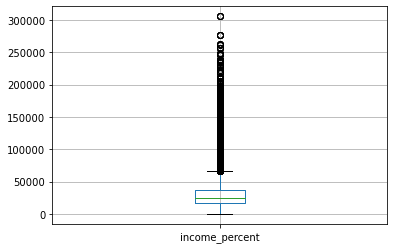

In [9]:
income_percent = pd.DataFrame(ineq_tc["income_percent"])
income_percent.boxplot()  # note that this plot shows a lot of data that are "outliers" if IQR is applied, so it wasn't adjusted via IQR

<AxesSubplot:>

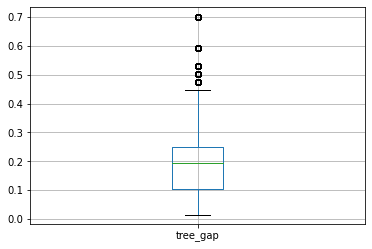

In [10]:
tree_gap = pd.DataFrame(ineq_tc["tree_gap"])
tree_gap.boxplot()

<AxesSubplot:>

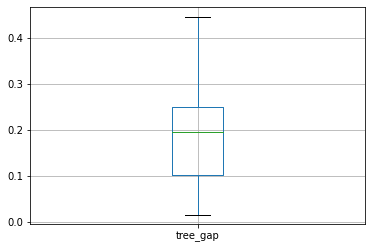

In [11]:
# apply IQR to remove tree_gap
q1 = tree_gap.quantile(0.25)
q3 = tree_gap.quantile(0.75)
iqr = q3-q1
tree_gap = tree_gap[~((tree_gap<(q1-1.5*iqr)) | (tree_gap>(q3+1.5*iqr)))]
tree_gap.boxplot()

<AxesSubplot:>

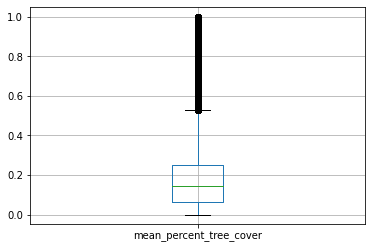

In [12]:
mean_tree_cover = pd.DataFrame(ineq_tc["mean_percent_tree_cover"])
mean_tree_cover.boxplot()

<AxesSubplot:>

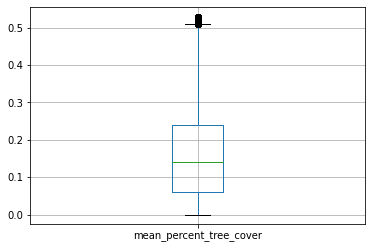

In [13]:
# apply IQR to remove mean_percent_tree_cover outliers
q1 = mean_tree_cover.quantile(0.25)
q3 = mean_tree_cover.quantile(0.75)
iqr = q3-q1
mean_tree_cover = mean_tree_cover[~((mean_tree_cover<(q1-1.5*iqr)) | (mean_tree_cover>(q3+1.5*iqr)))]
mean_tree_cover.boxplot()

In [92]:
# add outlier adjusted data back into the datatset
ineq_tc["tree_gap"] = tree_gap
ineq_tc["mean_percent_tree_cover"] = mean_tree_cover
ineq_tc = ineq_tc.dropna() # drop no data entries
ineq_tc.describe() 

,mean_percent_tree_cover,tree_gap,income_percent,income_group,pop_dens_group
count,387167.000000,387167.000000,387167.000000,387167.000000,387167.000000
mean,0.161327,0.184206,30177.441913,2.131279,3.349604
std,0.121952,0.086534,18841.869457,1.082733,0.476845
min,0.000000,0.015537,118.000000,1.000000,3.000000
25%,0.060791,0.096380,17616.000000,1.000000,3.000000
50%,0.139279,0.194592,25285.000000,2.000000,3.000000
75%,0.239496,0.244978,36772.000000,3.000000,4.000000
max,0.528582,0.445957,305700.000000,4.000000,4.000000


#### Skew and Kurt Analysis

In [15]:
# calculate the skewness for tree_gap, mean_percent_tree_cover and income_percent
# Skewness = 0: Then normally distributed.
# Skewness > 0: Then more weight in the left tail of the distribution.
# Skewness < 0: Then more weight in the right tail of the distribution.
income_percent_skew = income_percent.skew()
tree_gap_skew = tree_gap.skew()
mean_tree_cover_skew = mean_tree_cover.skew()

In [16]:
# calculate the kurtosis  for tree_gap, mean_percent_tree_cover and income_percent
# kurtosis for normal distribution is equal to 3.
# For a distribution having kurtosis < 3: It is called playkurtic.
# For a distribution having kurtosis > 3, It is called leptokurtic and it signifies that it tries to produce more outliers rather than the normal distribution.
income_percent_kurt = income_percent.kurt()
tree_gap_kurt = tree_gap.kurt()
mean_tree_cover_kurt = mean_tree_cover.kurt()

In [17]:
print("income_percent skew: " + str(income_percent_skew))
print("--------------------------------------")
print("tree_gap_skew: " + str(tree_gap_skew))
print("--------------------------------------")
print("mean_tree_cover_skew: " + str(mean_tree_cover_skew))
print("--------------------------------------")
print("income_percent_kurt: " + str(income_percent_kurt))
print("--------------------------------------")
print("tree_gap_kurt: " + str(tree_gap_kurt))
print("--------------------------------------")
print("mean_tree_cover_kurt:" + str(mean_tree_cover_kurt))
print("--------------------------------------")

income_percent skew: income_percent    2.373856
dtype: float64
--------------------------------------
tree_gap_skew: tree_gap    0.222618
dtype: float64
--------------------------------------
mean_tree_cover_skew: mean_percent_tree_cover    0.724803
dtype: float64
--------------------------------------
income_percent_kurt: income_percent    10.376055
dtype: float64
--------------------------------------
tree_gap_kurt: tree_gap   -0.224469
dtype: float64
--------------------------------------
mean_tree_cover_kurt:mean_percent_tree_cover   -0.184217
dtype: float64
--------------------------------------


<Figure size 432x288 with 0 Axes>

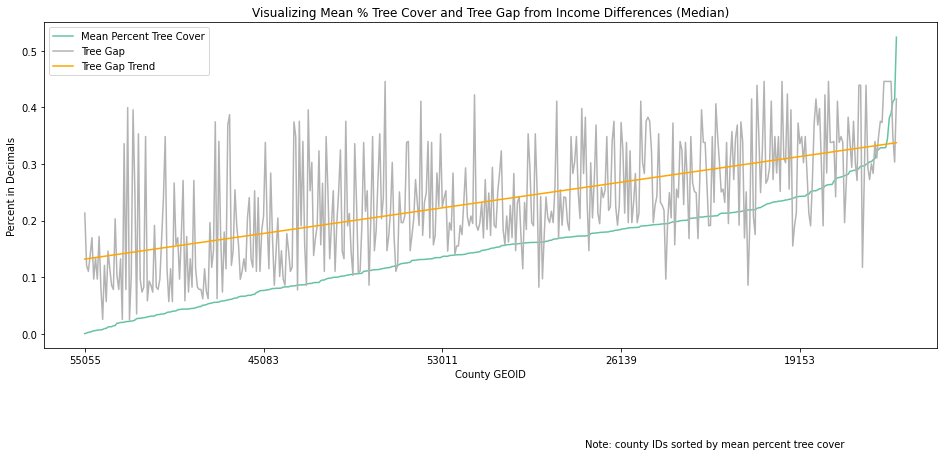

In [97]:
# visualizing relationship between mean percent tree cover in a county vs % tree cover gap between high income / low income areas sorted by tree_gap
plt.figure()
# sort_bytreegap = ineq_tc.copy()
# sort_bytreegap = sort_bytreegap.drop(columns=["income_percent", "income_group", "pop_dens_group"])
# sort_bytreegap = sort_bytreegap.groupby("census_block").median()
# sort_bytreegap = sort_bytreegap.sort_values(by=["tree_gap"])

# # other quantiles
# sort_bytreegap_75 = sort_bytreegap.groupby("census_block").quantile(0.75)
# sort_bytreegap_25 = sort_bytreegap.groupby("census_block").quantile(0.25)
# sort_bytreegap_75 = sort_bytreegap_75.sort_values(by=["tree_gap"])
# sort_bytreegap_25 = sort_bytreegap_25.sort_values(by=["tree_gap"])

# # sort_bytreegap.plot(figsize=(16,6), colormap='Set2') # note the scale is from 0 - 50%

# sort by mean percent tree cover
sort_bytc = ineq_tc.copy()
sort_bytc = sort_bytc.drop(columns=["income_percent", "income_group", "pop_dens_group"])
sort_bytc = sort_bytc.groupby("census_block").median()
sort_bytc = sort_bytc.sort_values(by=["mean_percent_tree_cover"])

sort_bytc.plot(figsize=(16,6), colormap='Set2') # note the scale is from 0 - 50%

X = np.array(range(0, len(sort_bytc))).reshape(-1, 1) # values converts it into a numpy array
Y = sort_bytc.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='orange')

plt.title("Visualizing Mean % Tree Cover and Tree Gap from Income Differences (Median)")
plt.legend(["Mean Percent Tree Cover", "Tree Gap", "Tree Gap Trend"])
plt.xlabel('County GEOID')
plt.ylabel('Percent in Decimals')
plt.text(280, -0.2, 'Note: county IDs sorted by mean percent tree cover')
plt.show()

In [ ]:
sort_bytreegap_75.plot(figsize=(16,6), colormap='Set2') # note the scale is from 0 - 50%

plt.title("Visualizing Mean % Tree Cover and Tree Gap from Income Differences (75th Percentile)")
plt.legend(["Mean Percent Tree Cover", "Tree Gap"])
plt.xlabel('County GEOID')
plt.ylabel('Percent in Decimals')
plt.text(280, -0.2, 'Note: county IDs sorted by tree gap')
plt.show()

In [ ]:
sort_bytreegap_25.plot(figsize=(16,6), colormap='Set2') # note the scale is from 0 - 50%

plt.title("Visualizing Mean % Tree Cover and Tree Gap from Income Differences (25th Percentile)")
plt.legend(["Mean Percent Tree Cover", "Tree Gap"])
plt.xlabel('County GEOID')
plt.ylabel('Percent in Decimals')
plt.text(280, -0.2, 'Note: county IDs sorted by tree gap')
plt.show()

#### Park Cover Dataset

In [21]:
# load percent park cover by county data
# =================================================================
park_cov = pd.read_csv(park_cover_data, sep=",", dtype=str)
park_cov = park_cov.astype({col: float for col in park_cov.columns[2:]})
park_cov = park_cov.drop(columns="NAME")
park_cov = park_cov.dropna()
park_cov = park_cov.drop_duplicates(subset=['GEOID'])
park_cov.head()

,GEOID,pc_park
0,01027,18.777
1,01091,0.665
2,01049,2.205
3,01019,7.050
4,01065,8.659


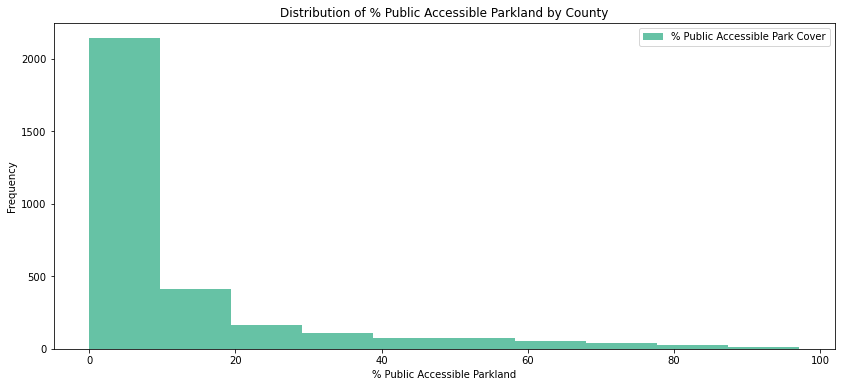

In [22]:
park_cov.plot.hist(figsize=(14,6), title="Distribution of % Public Accessible Parkland by County",  colormap='Set2')
plt.legend(["% Public Accessible Park Cover"])
plt.xlabel('% Public Accessible Parkland')
plt.show()

##### <b> 2010 Health dataset </b>

In [23]:
health_data = pd.read_excel("2010 County Health Rankings National Data_v2.xls", sheet_name = "Ranked Measure Data", header = [1], usecols = [0, 1, 2, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
health_data.rename(columns = {'Sample Size.2':'Sample Size'}, inplace = True)
health_data.drop('FIPS', axis = 1, inplace = True)
health_data.index = health_data.index + 1

In [24]:
health_data.dropna(axis = 0, how = 'all', inplace = True)
health_data.dropna(axis = 1, how = 'all', inplace = True)

In [25]:
health_data

,State,County,Sample Size.1,Physically Unhealthy Days,95% CI - Low.2,95% CI - High.2,Quartile.2,Sample Size,Mentally Unhealthy Days,95% CI - Low.3,95% CI - High.3,Quartile.3
1,Alabama,Autauga,255.0,5.48,4.16,6.80,4,258.0,4.14,2.78,5.49,2
2,Alabama,Baldwin,960.0,3.57,2.86,4.28,1,964.0,4.06,3.23,4.89,2
3,Alabama,Barbour,187.0,6.11,3.86,8.36,4,186.0,3.84,2.39,5.30,2
4,Alabama,Bibb,182.0,4.22,2.82,5.62,2,180.0,5.31,3.40,7.22,4
5,Alabama,Blount,247.0,5.62,3.94,7.30,4,249.0,4.47,2.76,6.19,3
...,...,...,...,...,...,...,...,...,...,...,...,...
3137,Wyoming,Sweetwater,2300.0,3.61,3.24,3.98,4,2331.0,3.99,3.57,4.42,4
3138,Wyoming,Teton,1180.0,2.65,2.16,3.13,1,1172.0,2.25,1.84,2.66,1
3139,Wyoming,Uinta,1351.0,4.13,3.57,4.68,4,1347.0,3.44,2.99,3.89,4
3140,Wyoming,Washakie,646.0,3.02,2.42,3.62,2,654.0,2.44,1.92,2.97,1


In [26]:
# add county id to health data
health_data["state_county"] = health_data["County"] + ", " + health_data["State"]
health_data["county_id"] = health_data['state_county'].map(ct_to_id.set_index('state_county')['county_id'])
health_data.head()

# note for unhealthy days:
# Average number of reported physically unhealthy days per month

,State,County,Sample Size.1,Physically Unhealthy Days,95% CI - Low.2,95% CI - High.2,Quartile.2,Sample Size,Mentally Unhealthy Days,95% CI - Low.3,95% CI - High.3,Quartile.3,state_county,county_id
1,Alabama,Autauga,255.0,5.48,4.16,6.80,4,258.0,4.14,2.78,5.49,2,"Autauga, Alabama",01001
2,Alabama,Baldwin,960.0,3.57,2.86,4.28,1,964.0,4.06,3.23,4.89,2,"Baldwin, Alabama",01003
3,Alabama,Barbour,187.0,6.11,3.86,8.36,4,186.0,3.84,2.39,5.30,2,"Barbour, Alabama",01005
4,Alabama,Bibb,182.0,4.22,2.82,5.62,2,180.0,5.31,3.40,7.22,4,"Bibb, Alabama",01007
5,Alabama,Blount,247.0,5.62,3.94,7.30,4,249.0,4.47,2.76,6.19,3,"Blount, Alabama",01009


In [27]:
health_data['Physically Unhealthy Days'].corr(health_data['Mentally Unhealthy Days'])

0.6261356817720176

### Combining Health, Income, Tree Cover Datasets

In [28]:
health_byct = pd.DataFrame(sort_bytreegap.index)
health_byct = health_byct.drop_duplicates(subset=['census_block'])
health_data = health_data.drop_duplicates(subset=['county_id'])

health_byct['PUD/month'] = health_byct['census_block'].map(health_data.set_index('county_id')['Physically Unhealthy Days'])
health_byct['MUD/month'] = health_byct['census_block'].map(health_data.set_index('county_id')['Mentally Unhealthy Days'])
health_byct = health_byct.dropna()
health_byct 

,census_block,PUD/month,MUD/month
0,42101,4.14,4.38
1,35043,3.70,3.13
2,35001,3.60,3.46
7,35013,3.66,3.15
8,48141,4.17,3.16
...,...,...,...
441,26049,4.02,4.18
442,47187,1.58,1.47
443,47165,3.47,3.76
444,47037,2.97,3.00


#### Income and Health

In [29]:
# plot income and unhealthy days
income_ud = ineq_tc.copy()
income_ud = income_ud.drop(columns=["mean_percent_tree_cover", "tree_gap", "pop_dens_group", "income_group"])


In [30]:
def plot_income_health(ud, col, quantile, input):
    data = input.copy()
    data = data.groupby("census_block").quantile(quantile)
    data[ud] = data.index.map(health_byct.set_index('census_block')[ud])
    data= data.sort_values(by=[ud])

    data = data.dropna()

    # normalize income_percent, and PUD/month
    min = data[col].min()
    max = data[col].max()
    data[col] = (data[col] - min)/(max - min)
    min = data[ud].min()
    max = data[ud].max()
    data[ud] = (data[ud]-min)/(max - min)

    return data

In [60]:
def plot_income_health_v2(ud, ud2, col, quantile, input):
    data = input.copy()
    data = data.groupby("census_block").quantile(quantile)
    data[ud] = data.index.map(health_byct.set_index('census_block')[ud])
    data= data.sort_values(by=[ud])

    data = data.dropna()

    # normalize income_percent, and PUD/month
    min = data[col].min()
    max = data[col].max()
    data[col] = (data[col] - min)/(max - min)
    min = data[ud].min()
    max = data[ud].max()
    data[ud] = (data[ud]-min)/(max - min)

    return data

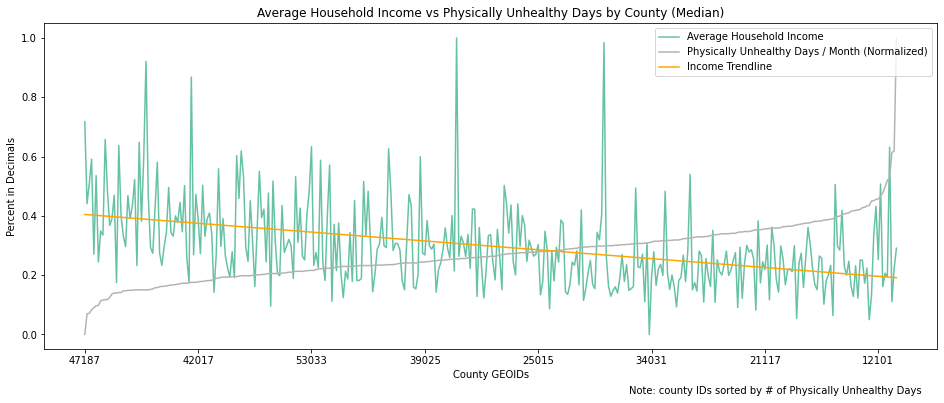

In [66]:
income_ud_median_pud = income_ud.copy()
income_ud_median_pud = plot_income_health('PUD/month', 'income_percent', 0.5, income_ud_median_pud)
income_ud_median_pud.plot(figsize=(16,6), colormap='Set2')

X = np.array(range(0, len(income_ud_median_pud))).reshape(-1, 1) # values converts it into a numpy array
Y = income_ud_median_pud.iloc[:, 0].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='orange')

plt.title("Average Household Income vs Physically Unhealthy Days by County (Median)")
plt.legend(["Average Household Income", "Physically Unhealthy Days / Month (Normalized)", "Income Trendline"])
plt.ylabel('Percent in Decimals')
plt.xlabel('County GEOIDs')
plt.text(240, -0.2, 'Note: county IDs sorted by # of Physically Unhealthy Days')
plt.show()

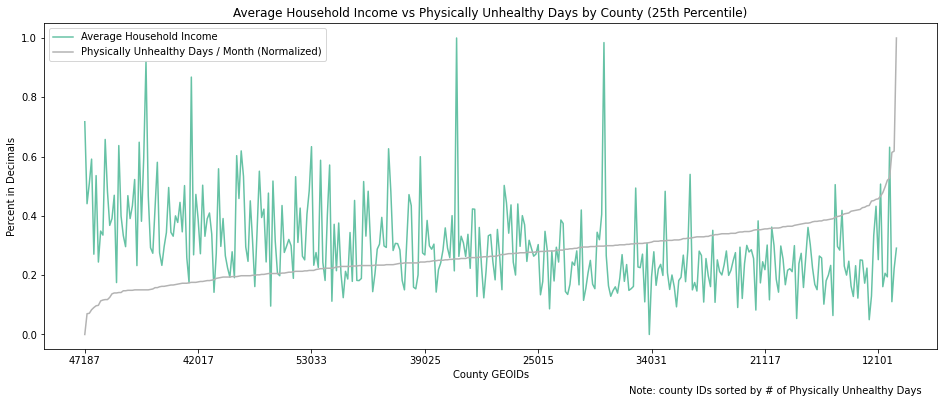

In [ ]:
income_ud_25_pud = income_ud.copy()
income_ud_25_pud = plot_income_health('PUD/month', 'income_percent', 0.25, income_ud_median_pud)
income_ud_25_pud.plot(figsize=(16,6), colormap='Set2')
plt.title("Average Household Income vs Physically Unhealthy Days by County (25th Percentile)")
plt.legend(["Average Household Income", "Physically Unhealthy Days / Month (Normalized)"])
plt.ylabel('Percent in Decimals')
plt.xlabel('County GEOIDs')
plt.text(240, -0.2, 'Note: county IDs sorted by # of Physically Unhealthy Days')
plt.show()

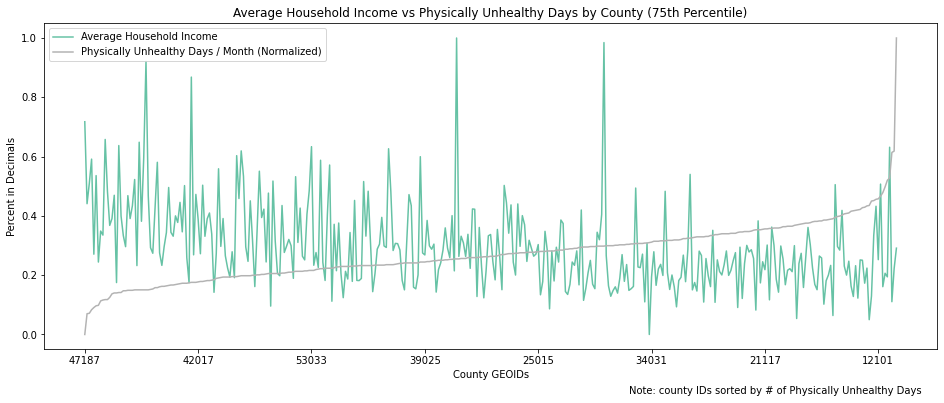

In [ ]:
income_ud_75_pud = income_ud.copy()
income_ud_75_pud = plot_income_health('PUD/month', 'income_percent', 0.75, income_ud_median_pud)
income_ud_75_pud.plot(figsize=(16,6), colormap='Set2')



plt.title("Average Household Income vs Physically Unhealthy Days by County (75th Percentile)")
plt.legend(["Average Household Income", "Physically Unhealthy Days / Month (Normalized)"])
plt.ylabel('Percent in Decimals')
plt.xlabel('County GEOIDs')
plt.text(240, -0.2, 'Note: county IDs sorted by # of Physically Unhealthy Days')
plt.show()

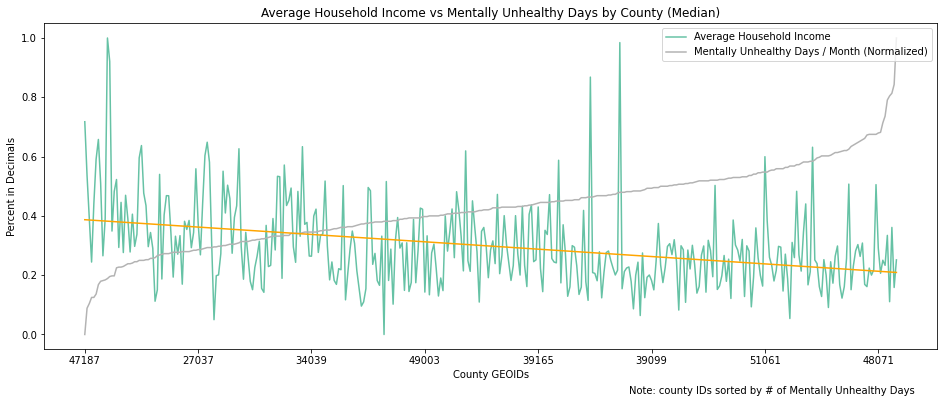

In [67]:
income_ud_median_mud = income_ud.copy()
income_ud_median_mud = plot_income_health('MUD/month', 'income_percent', 0.5, income_ud_median_mud)
income_ud_median_mud.plot(figsize=(16,6), colormap='Set2')

X = np.array(range(0, len(income_ud_median_mud))).reshape(-1, 1) # values converts it into a numpy array
Y = income_ud_median_mud.iloc[:, 0].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='orange')

plt.title("Average Household Income vs Mentally Unhealthy Days by County (Median)")
plt.legend(["Average Household Income", "Mentally Unhealthy Days / Month (Normalized)"])
plt.ylabel('Percent in Decimals')
plt.xlabel('County GEOIDs')
plt.text(240, -0.2, 'Note: county IDs sorted by # of Mentally Unhealthy Days')
plt.show()

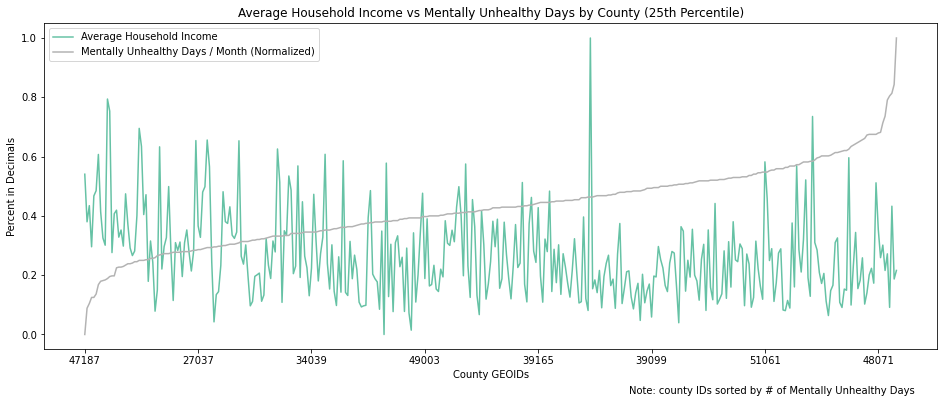

In [ ]:
income_ud_25_mud = income_ud.copy()
income_ud_25_mud = plot_income_health('MUD/month', 'income_percent', 0.25, income_ud_25_mud)
income_ud_25_mud.plot(figsize=(16,6), colormap='Set2')
plt.title("Average Household Income vs Mentally Unhealthy Days by County (25th Percentile)")
plt.legend(["Average Household Income", "Mentally Unhealthy Days / Month (Normalized)"])
plt.ylabel('Percent in Decimals')
plt.xlabel('County GEOIDs')
plt.text(240, -0.2, 'Note: county IDs sorted by # of Mentally Unhealthy Days')
plt.show()

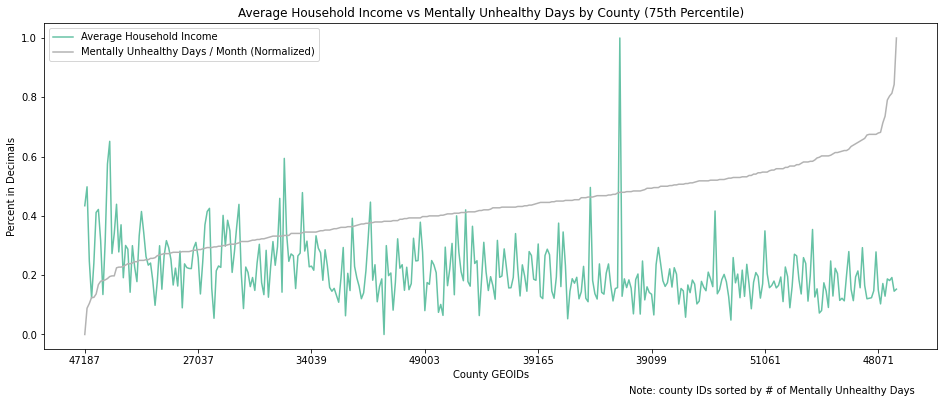

In [ ]:
income_ud_75_mud = income_ud.copy()
income_ud_75_mud = plot_income_health('MUD/month', 'income_percent', 0.75, income_ud_75_mud)
income_ud_75_mud.plot(figsize=(16,6), colormap='Set2')
plt.title("Average Household Income vs Mentally Unhealthy Days by County (75th Percentile)")
plt.legend(["Average Household Income", "Mentally Unhealthy Days / Month (Normalized)"])
plt.ylabel('Percent in Decimals')
plt.xlabel('County GEOIDs')
plt.text(240, -0.2, 'Note: county IDs sorted by # of Mentally Unhealthy Days')
plt.show()

#### Mean Percent Tree Cover & Health

In [69]:
# combine tree_gap with PUD
ud_meantc = sort_bytreegap.copy()
ud_meantc = ud_meantc.drop(columns=['tree_gap'])
ud_meantc = ud_meantc.sort_values(by=['mean_percent_tree_cover'])
ud_meantc['PUD/month'] = ud_meantc.index.map(health_byct.set_index('census_block')['PUD/month'])
ud_meantc['MUD/month'] = ud_meantc.index.map(health_byct.set_index('census_block')['MUD/month'])
ud_meantc= ud_meantc.dropna()
# normalize for plot
ud_meantc['PUD/month'] = (ud_meantc['PUD/month'] -  ud_meantc['PUD/month'].min()) / (ud_meantc['PUD/month'].max()- ud_meantc['PUD/month'].min())
ud_meantc['MUD/month'] = (ud_meantc['MUD/month'] -  ud_meantc['MUD/month'].min()) / (ud_meantc['MUD/month'].max()- ud_meantc['MUD/month'].min())

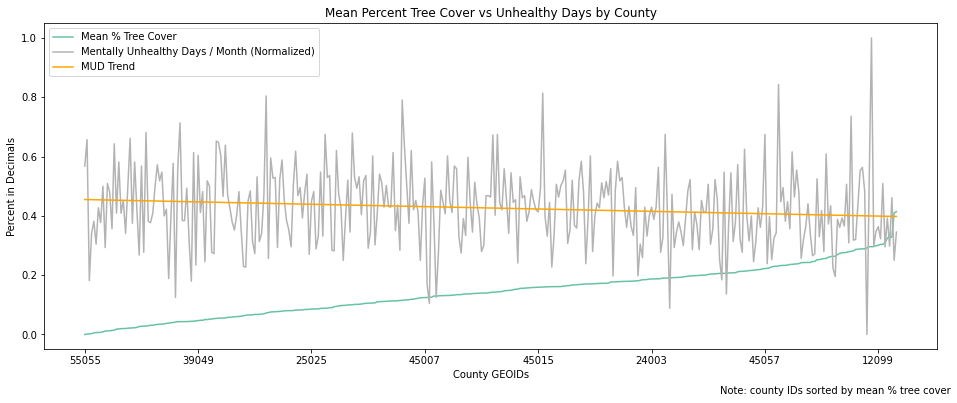

In [104]:
ud_meantc_mud = ud_meantc.copy()
ud_meantc_mud = ud_meantc_mud.drop(columns=['PUD/month'])

ud_meantc_mud.plot(figsize=(16,6), colormap='Set2')

X = np.array(range(0, len(ud_meantc_mud))).reshape(-1, 1) # values converts it into a numpy array
Y = ud_meantc_mud.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='orange')

plt.title("Mean Percent Tree Cover vs Unhealthy Days by County")
plt.legend(["Mean % Tree Cover", "Mentally Unhealthy Days / Month (Normalized)", "MUD Trend"])
plt.ylabel('Percent in Decimals')
plt.xlabel('County GEOIDs')
plt.text(280, -0.2, 'Note: county IDs sorted by mean % tree cover')
plt.show()

In [105]:
print(Y_pred.max())
print(Y_pred.min())
print(Y_pred.max() - Y_pred.min())

0.4551822191272052
0.3980717692242762
0.05711044990292902


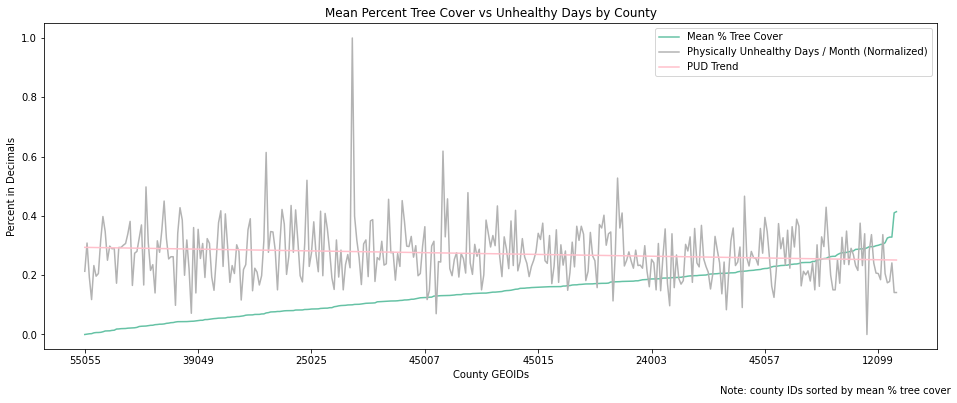

In [106]:
ud_meantc_pud = ud_meantc.copy()
ud_meantc_pud = ud_meantc_pud.drop(columns=['MUD/month'])

ud_meantc_pud.plot(figsize=(16,6), colormap='Set2')

X = np.array(range(0, len(ud_meantc_pud))).reshape(-1, 1) # values converts it into a numpy array
Y = ud_meantc_pud.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='pink')

plt.title("Mean Percent Tree Cover vs Unhealthy Days by County")
plt.legend(["Mean % Tree Cover", "Physically Unhealthy Days / Month (Normalized)", "PUD Trend"])
plt.ylabel('Percent in Decimals')
plt.xlabel('County GEOIDs')
plt.text(280, -0.2, 'Note: county IDs sorted by mean % tree cover')
plt.show()

In [107]:
print(Y_pred.max())
print(Y_pred.min())
print(Y_pred.max() - Y_pred.min())

0.2938761559611827
0.2511798656919439
0.042696290269238824


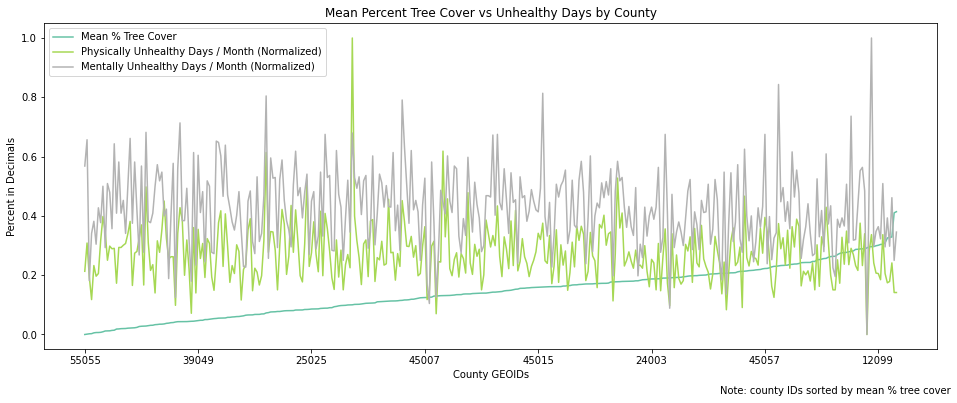

In [109]:
ud_meantc.plot(figsize=(16,6), colormap='Set2')

# X = np.array(range(0, len(ud_meantc))).reshape(-1, 1) # values converts it into a numpy array
# Y = ud_meantc.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
# linear_regressor = LinearRegression()  # create object for the class
# linear_regressor.fit(X, Y)  # perform linear regression
# Y_pred = linear_regressor.predict(X)  # make predictions
# plt.plot(X, Y_pred, color='orange')

# X = np.array(range(0, len(ud_meantc))).reshape(-1, 1) # values converts it into a numpy array
# Y = ud_meantc.iloc[:, 2].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
# linear_regressor = LinearRegression()  # create object for the class
# linear_regressor.fit(X, Y)  # perform linear regression
# Y_pred = linear_regressor.predict(X)  # make predictions
# plt.plot(X, Y_pred, color='pink')

plt.title("Mean Percent Tree Cover vs Unhealthy Days by County")
plt.legend(["Mean % Tree Cover", "Physically Unhealthy Days / Month (Normalized)", "Mentally Unhealthy Days / Month (Normalized)", "MUD Trend", "PUD Trend"])
plt.ylabel('Percent in Decimals')
plt.xlabel('County GEOIDs')
plt.text(280, -0.2, 'Note: county IDs sorted by mean % tree cover')
plt.show()

#### Tree Gap and Health

In [111]:
# combine tree_gap with PUD
pud_treegap = sort_bytreegap
pud_treegap = pud_treegap.drop(columns=['mean_percent_tree_cover'])
pud_treegap['PUD/month'] = pud_treegap.index.map(health_byct.set_index('census_block')['PUD/month'])
pud_treegap['MUD/month'] = pud_treegap.index.map(health_byct.set_index('census_block')['MUD/month'])
pud_treegap = pud_treegap.dropna()
# normalize for plot
pud_treegap['PUD/month'] = (pud_treegap['PUD/month'] -  pud_treegap['PUD/month'].min()) / (pud_treegap['PUD/month'].max()-pud_treegap['PUD/month'].min())
pud_treegap['MUD/month'] = (pud_treegap['MUD/month'] -  pud_treegap['MUD/month'].min()) / (pud_treegap['MUD/month'].max()- pud_treegap['MUD/month'].min())

0.010499745427257982
-0.11540414403595992


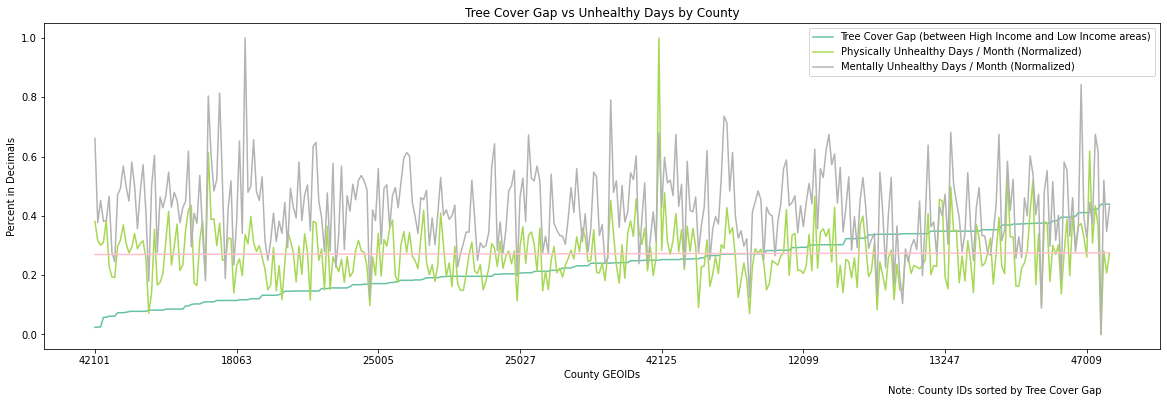

0.2752436461053293
0.2698123755477973
0.005431270557532009


In [113]:
print(pud_treegap['PUD/month'].corr(pud_treegap['tree_gap'])) 
print(pud_treegap['MUD/month'].corr(pud_treegap['tree_gap'])) 
pud_treegap.plot(figsize=(20, 6), colormap='Set2')

X = np.array(range(0, len(pud_treegap))).reshape(-1, 1) # values converts it into a numpy array
Y = pud_treegap.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='pink')


plt.title("Tree Cover Gap vs Unhealthy Days by County")
plt.legend(["Tree Cover Gap (between High Income and Low Income areas)", "Physically Unhealthy Days / Month (Normalized)", "Mentally Unhealthy Days / Month (Normalized)"])
plt.ylabel('Percent in Decimals')
plt.xlabel('County GEOIDs')
plt.text(280, -0.2, 'Note: County IDs sorted by Tree Cover Gap')
plt.show()

print(Y_pred.max())
print(Y_pred.min())
print(Y_pred.max() - Y_pred.min())


In [ ]:
# # combine tree_gap with MUD
# mud_treegap = sort_bytreegap
# mud_treegap = mud_treegap.drop(columns=['mean_percent_tree_cover'])
# mud_treegap['MUD/month'] = mud_treegap.index.map(health_byct.set_index('census_block')['MUD/month'])
# mud_treegap = mud_treegap.dropna()
# # normalize for plot
# mud_treegap['MUD/month'] = (mud_treegap['MUD/month'] -  mud_treegap['MUD/month'].min()) / (mud_treegap['MUD/month'].max()- mud_treegap['MUD/month'].min())

In [ ]:
# print(pud_treegap['PUD/month'].corr(pud_treegap['tree_gap'])) 
# mud_treegap.plot(figsize=(20, 6), colormap='Set2')
# plt.title("Tree Cover Gap vs Unhealthy Days by County")
# plt.legend(["Tree Cover Gap (between High Income and Low Income areas)", "Mentally Unhealthy Days / Month (Normalized)"])
# plt.ylabel('Percent in Decimals')
# plt.xlabel('County GEOIDs')
# plt.text(280, -0.2, 'Note: county IDs sorted by tree cover gap')
# plt.show()

#### % Public Accessible Parkland Cover vs Health

In [117]:
# combine park cover with PUD / MUD
pud_park = park_cov.copy()
pud_park = pud_park.sort_values(by=['pc_park'])
pud_park['pc_park'] = pud_park['pc_park']/100
pud_park['PUD/month'] = pud_park["GEOID"].map(health_byct.set_index('census_block')['PUD/month'])
pud_park['MUD/month'] = pud_park["GEOID"].map(health_byct.set_index('census_block')['MUD/month'])
pud_park = pud_park.dropna()
# normalize for plot
pud_park['PUD/month'] = (pud_park['PUD/month'] -  pud_park['PUD/month'].min()) / (pud_park['PUD/month'].max()- pud_park['PUD/month'].min())
pud_park['MUD/month'] = (pud_park['MUD/month'] -  pud_park['MUD/month'].min()) / (pud_park['MUD/month'].max()- pud_park['MUD/month'].min())

pud_park = pud_park.set_index('GEOID')

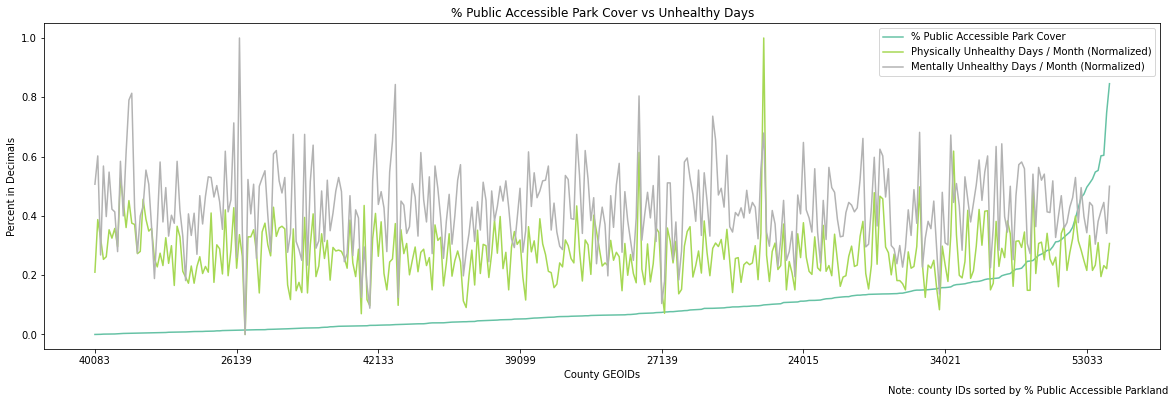

In [118]:
pud_park = pud_park.copy()

pud_park.plot(figsize=(20,6), colormap='Set2')


plt.title("% Public Accessible Park Cover vs Unhealthy Days")
plt.legend(["% Public Accessible Park Cover", "Physically Unhealthy Days / Month (Normalized)", "Mentally Unhealthy Days / Month (Normalized)"])
plt.ylabel('Percent in Decimals')
plt.xlabel('County GEOIDs')
plt.text(280, -0.2, 'Note: county IDs sorted by % Public Accessible Parkland')
plt.show()

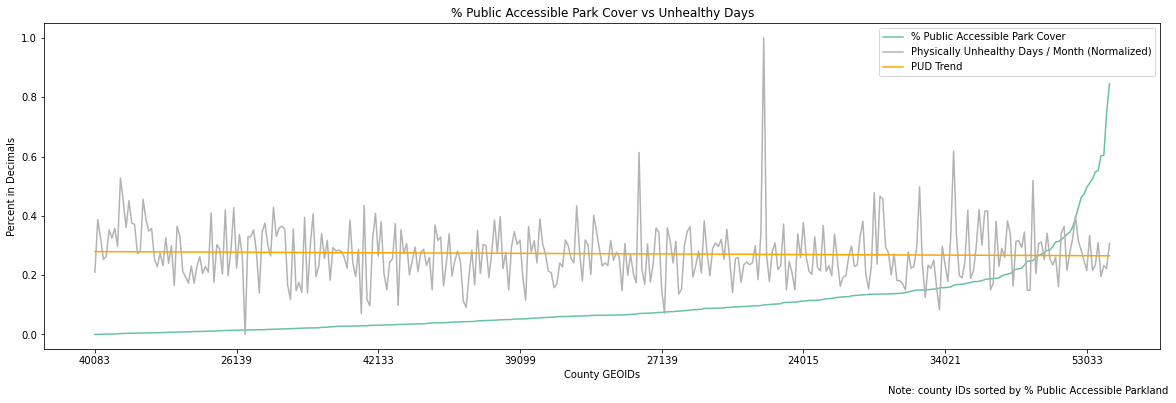

0.2796044374518278
0.26545158420129883
0.014152853250528952


In [120]:
pud_park_pud = pud_park.copy()
pud_park_pud = pud_park_pud.drop(columns=['MUD/month'])

pud_park_pud.plot(figsize=(20,6), colormap='Set2')

X = np.array(range(0, len(pud_park_pud))).reshape(-1, 1) # values converts it into a numpy array
Y = pud_park_pud.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='orange')

plt.title("% Public Accessible Park Cover vs Unhealthy Days")
plt.legend(["% Public Accessible Park Cover", "Physically Unhealthy Days / Month (Normalized)", "PUD Trend"])
plt.ylabel('Percent in Decimals')
plt.xlabel('County GEOIDs')
plt.text(280, -0.2, 'Note: county IDs sorted by % Public Accessible Parkland')
plt.show()

print(Y_pred.max())
print(Y_pred.min())
print(Y_pred.max() - Y_pred.min())


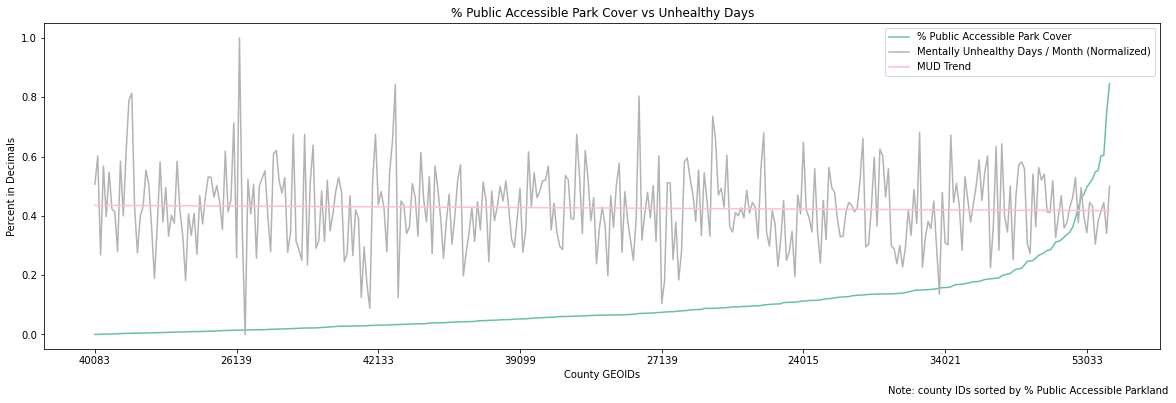

0.4357102008947413
0.4175437874567401
0.018166413438001183


In [119]:
pud_park_mud = pud_park.copy()
pud_park_mud = pud_park_mud.drop(columns=['PUD/month'])

pud_park_mud.plot(figsize=(20,6), colormap='Set2')

X = np.array(range(0, len(pud_park_mud))).reshape(-1, 1) # values converts it into a numpy array
Y = pud_park_mud.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='pink')

plt.title("% Public Accessible Park Cover vs Unhealthy Days")
plt.legend(["% Public Accessible Park Cover", "Mentally Unhealthy Days / Month (Normalized)", "MUD Trend"])
plt.ylabel('Percent in Decimals')
plt.xlabel('County GEOIDs')
plt.text(280, -0.2, 'Note: county IDs sorted by % Public Accessible Parkland')
plt.show()

print(Y_pred.max())
print(Y_pred.min())
print(Y_pred.max() - Y_pred.min())
